In [1]:
%matplotlib notebook
import h5py
import copy
import numpy as np
import matplotlib.pyplot as plt
from plotutility import estimatorscope, estimatorsilentscope
from pythonwrapper import pwrap

In [2]:
#Earth angular rate in ECEF (rad/s)
earth_rate_ecef= pwrap.lin_Vector3d([0.000000707063506E-4,-0.000001060595259E-4,0.729211585530000E-4])

In [3]:
class TimeEstimator:
    def __init__(self,maxcycledelay=2,cycle_duration=120_000_000):
        """estimator that tries to prevent time going backwards.
        
            Args:
                maxcycledelay(int): 
                    Maximum difference in time between read times and piksi times in control cycles.
                cycle_duration(int): 
                    Length of a control cycle in ns."""
        self.current_GPS_time= 0
        self.cycles_since_reading= 0
        self.cycle_duration= cycle_duration
        self._num_neg_steps= 0
        self.maxcycledelay= maxcycledelay
        
    def update(self,gps_time):
        """Control cycle update. gps_time is an int ns or 0 if not available"""
        t= gps_time
        if t: #valid gps time reading
            if (t < self.current_GPS_time):
                self._num_neg_steps+=1
            self.current_GPS_time= t
            self.cycles_since_reading= 0
        elif self.current_GPS_time: #invalid gps time reading but valid stored time
            if self.cycles_since_reading>=(self.maxcycledelay-1):
                self.current_GPS_time+= self.cycle_duration
            else:
                self.cycles_since_reading+=1
    
    def num_negative_steps(self):
        """Returns the number of times time has gone backwards"""
        return self._num_neg_steps

In [4]:
class OrbitEstimatorPropagateGPS:
    def __init__(self,time_estimator=TimeEstimator()):
        """Orbit estimator that just propagate the most recent GPS readings"""
        self.time_estimator= time_estimator
        self.orbit=pwrap.orb_Orbit()
        
    def update(self,sensors):
        self.time_estimator.update(int(sensors['t']))
        inorbit= pwrap.orb_Orbit(sensors['t'],pwrap.lin_Vector3d(sensors['r']),pwrap.lin_Vector3d(sensors['v']))
        if inorbit.valid():
            self.orbit= inorbit
        elif self.time_estimator.current_GPS_time:
            self.orbit.update(self.time_estimator.current_GPS_time,earth_rate_ecef)

    def norm_pos_error_m(self,sensors,truth):
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            o= copy.deepcopy(self.orbit)
            o.update(trueorbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.recef())-np.array(o.recef())))
        else:
            return float(np.nan)
        
    def norm_vel_error_mpers(self,sensors,truth):
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            o= copy.deepcopy(self.orbit)
            o.update(trueorbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.vecef())-np.array(o.vecef())))
        else:
            return float(np.nan)

In [5]:
!ls test-files 

Gracetest.hdf5           gengracetest.py          utility.py
__pycache__              gps-from-matlab-sim.hdf5


In [6]:
with h5py.File("test-files/gps-from-matlab-sim.hdf5","r") as f:  
    psimtruth= f['truth'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
    psimsensors= f['sensors'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
with h5py.File("test-files/Gracetest.hdf5","r") as f:  
    gracetruth= f['truth'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
    gracesensors= f['sensors'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])

In [7]:
f=h5py.File("test-files/gps-from-matlab-sim.hdf5","r")

In [8]:
f.attrs['const']['gps_max_angle']*180/np.pi

array([60.])

<IPython.core.display.Javascript object>


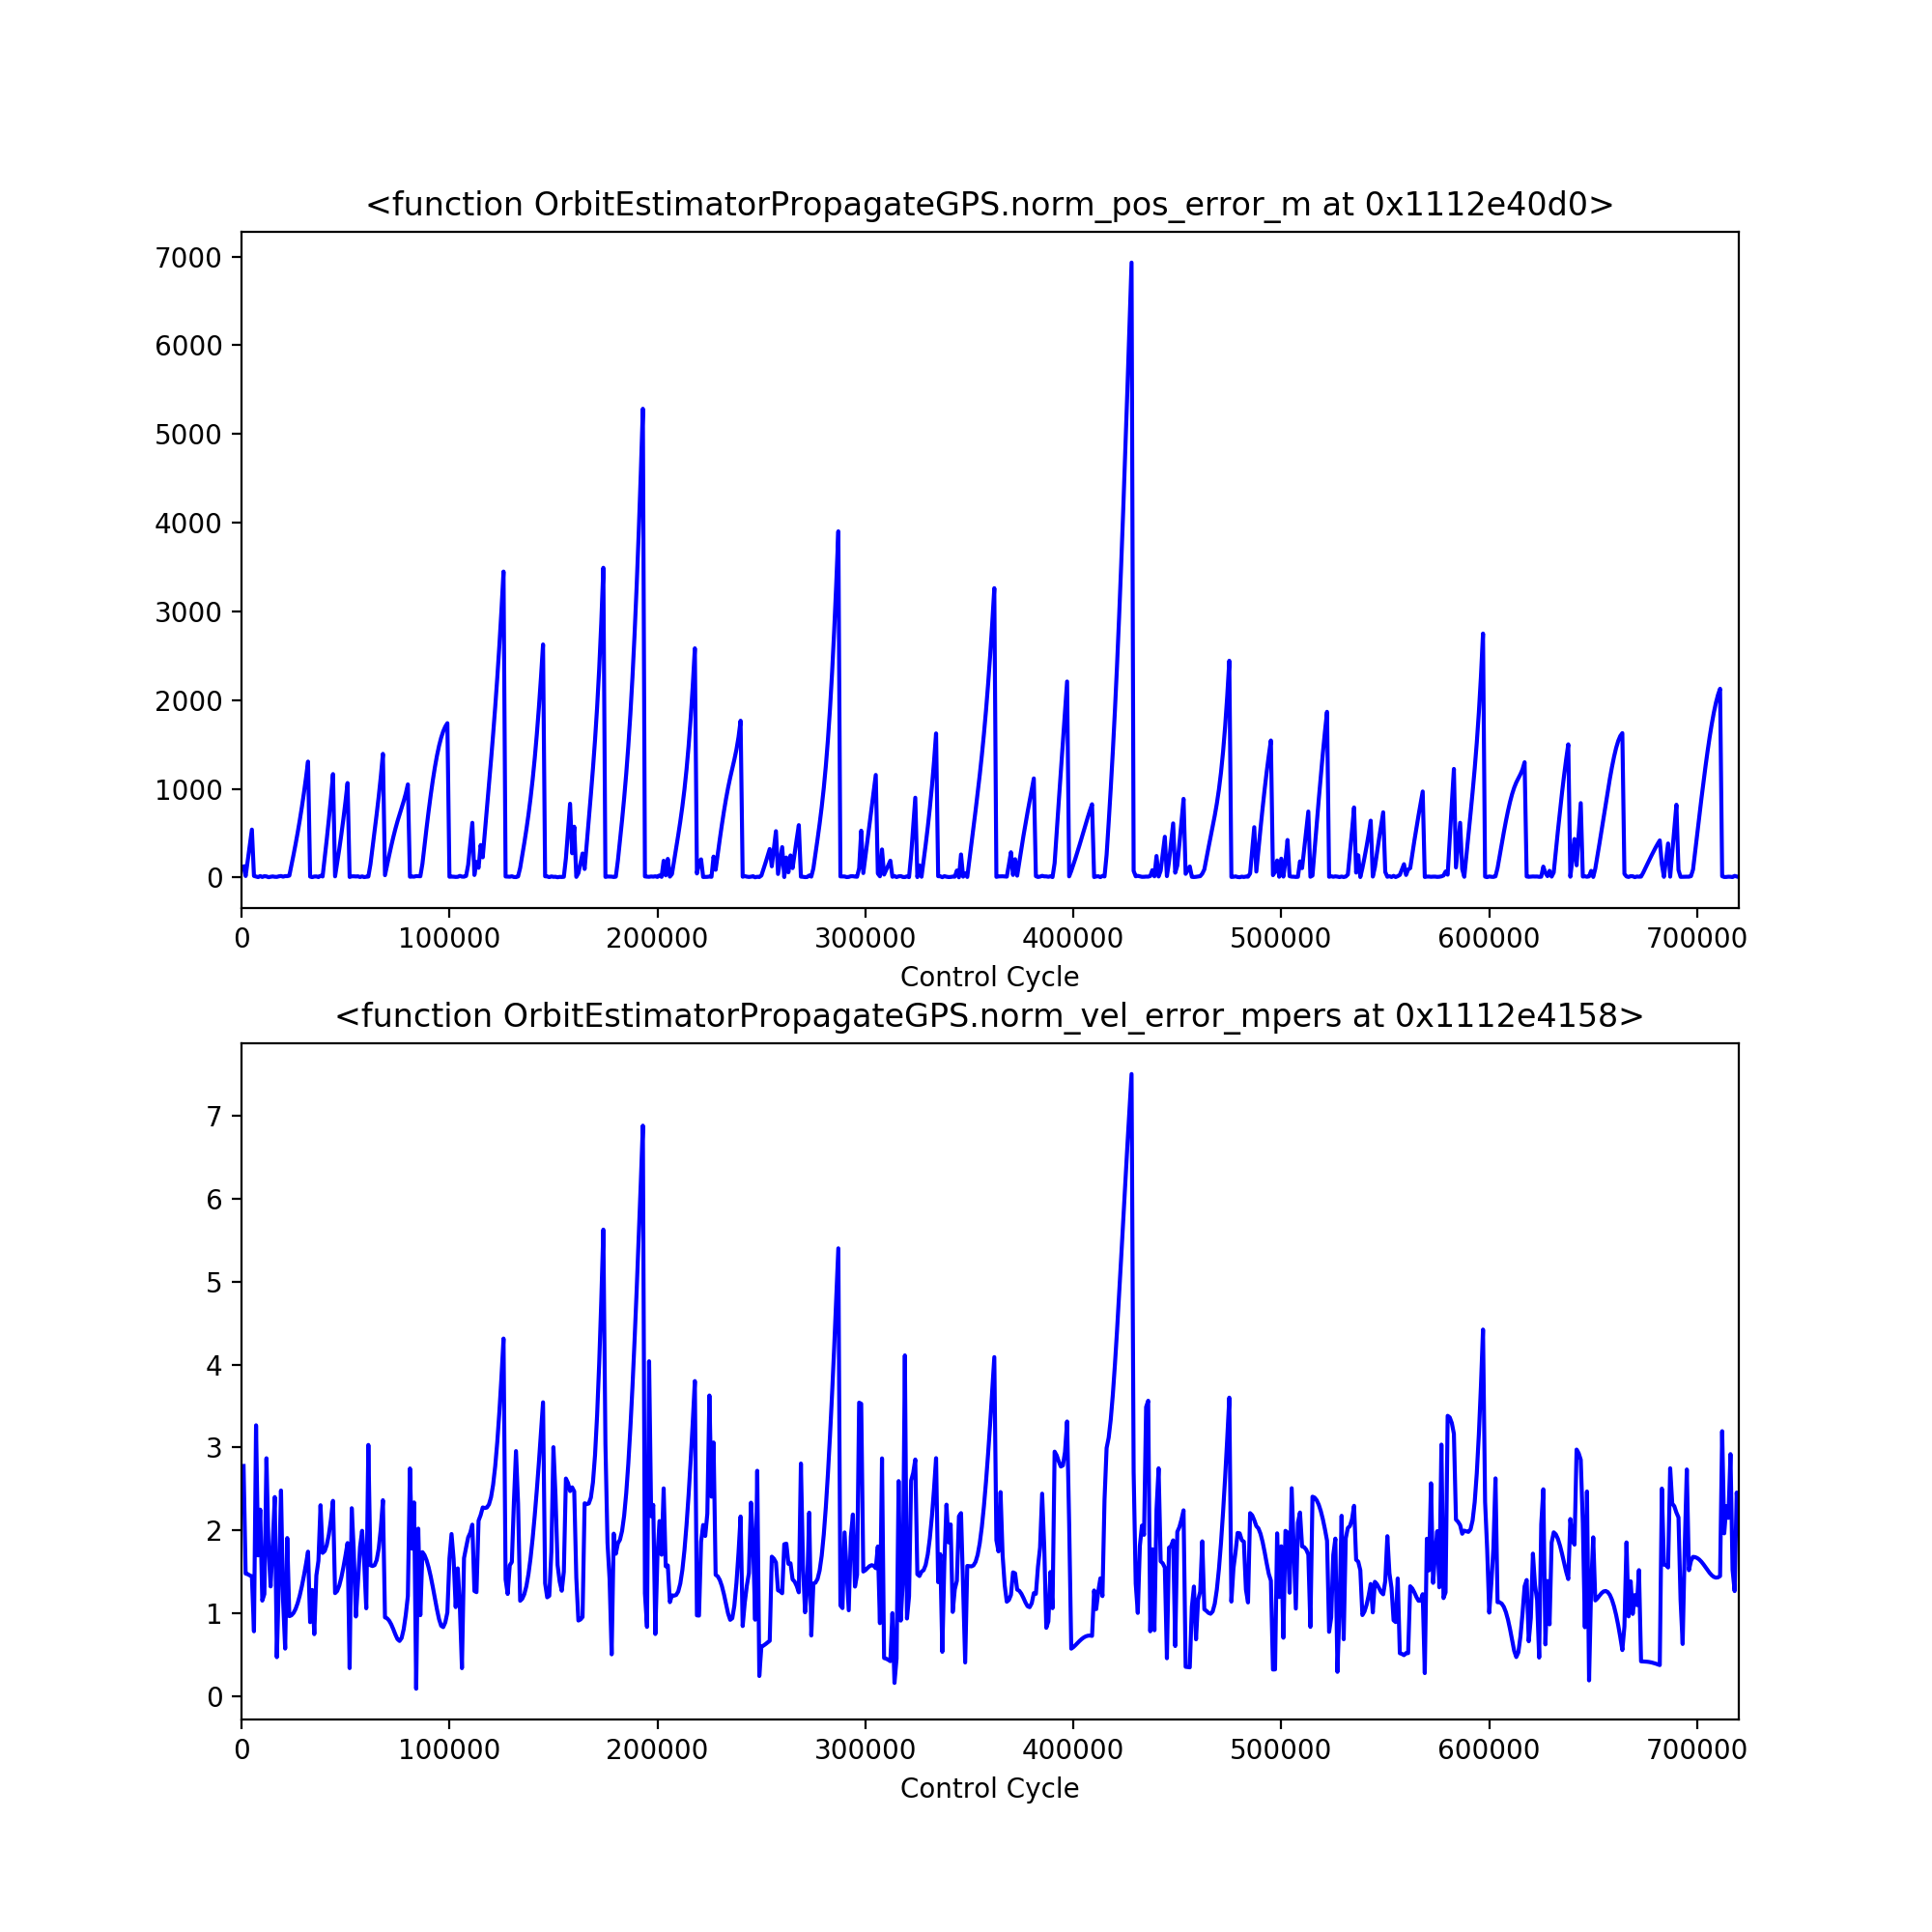

In [11]:
psimb=[]
samplerate=1000
a= estimatorscope(OrbitEstimatorPropagateGPS(),psimtruth,psimsensors,psimb,samplerate,
                      [OrbitEstimatorPropagateGPS.norm_pos_error_m,
                       OrbitEstimatorPropagateGPS.norm_vel_error_mpers])
plt.show()

<IPython.core.display.Javascript object>


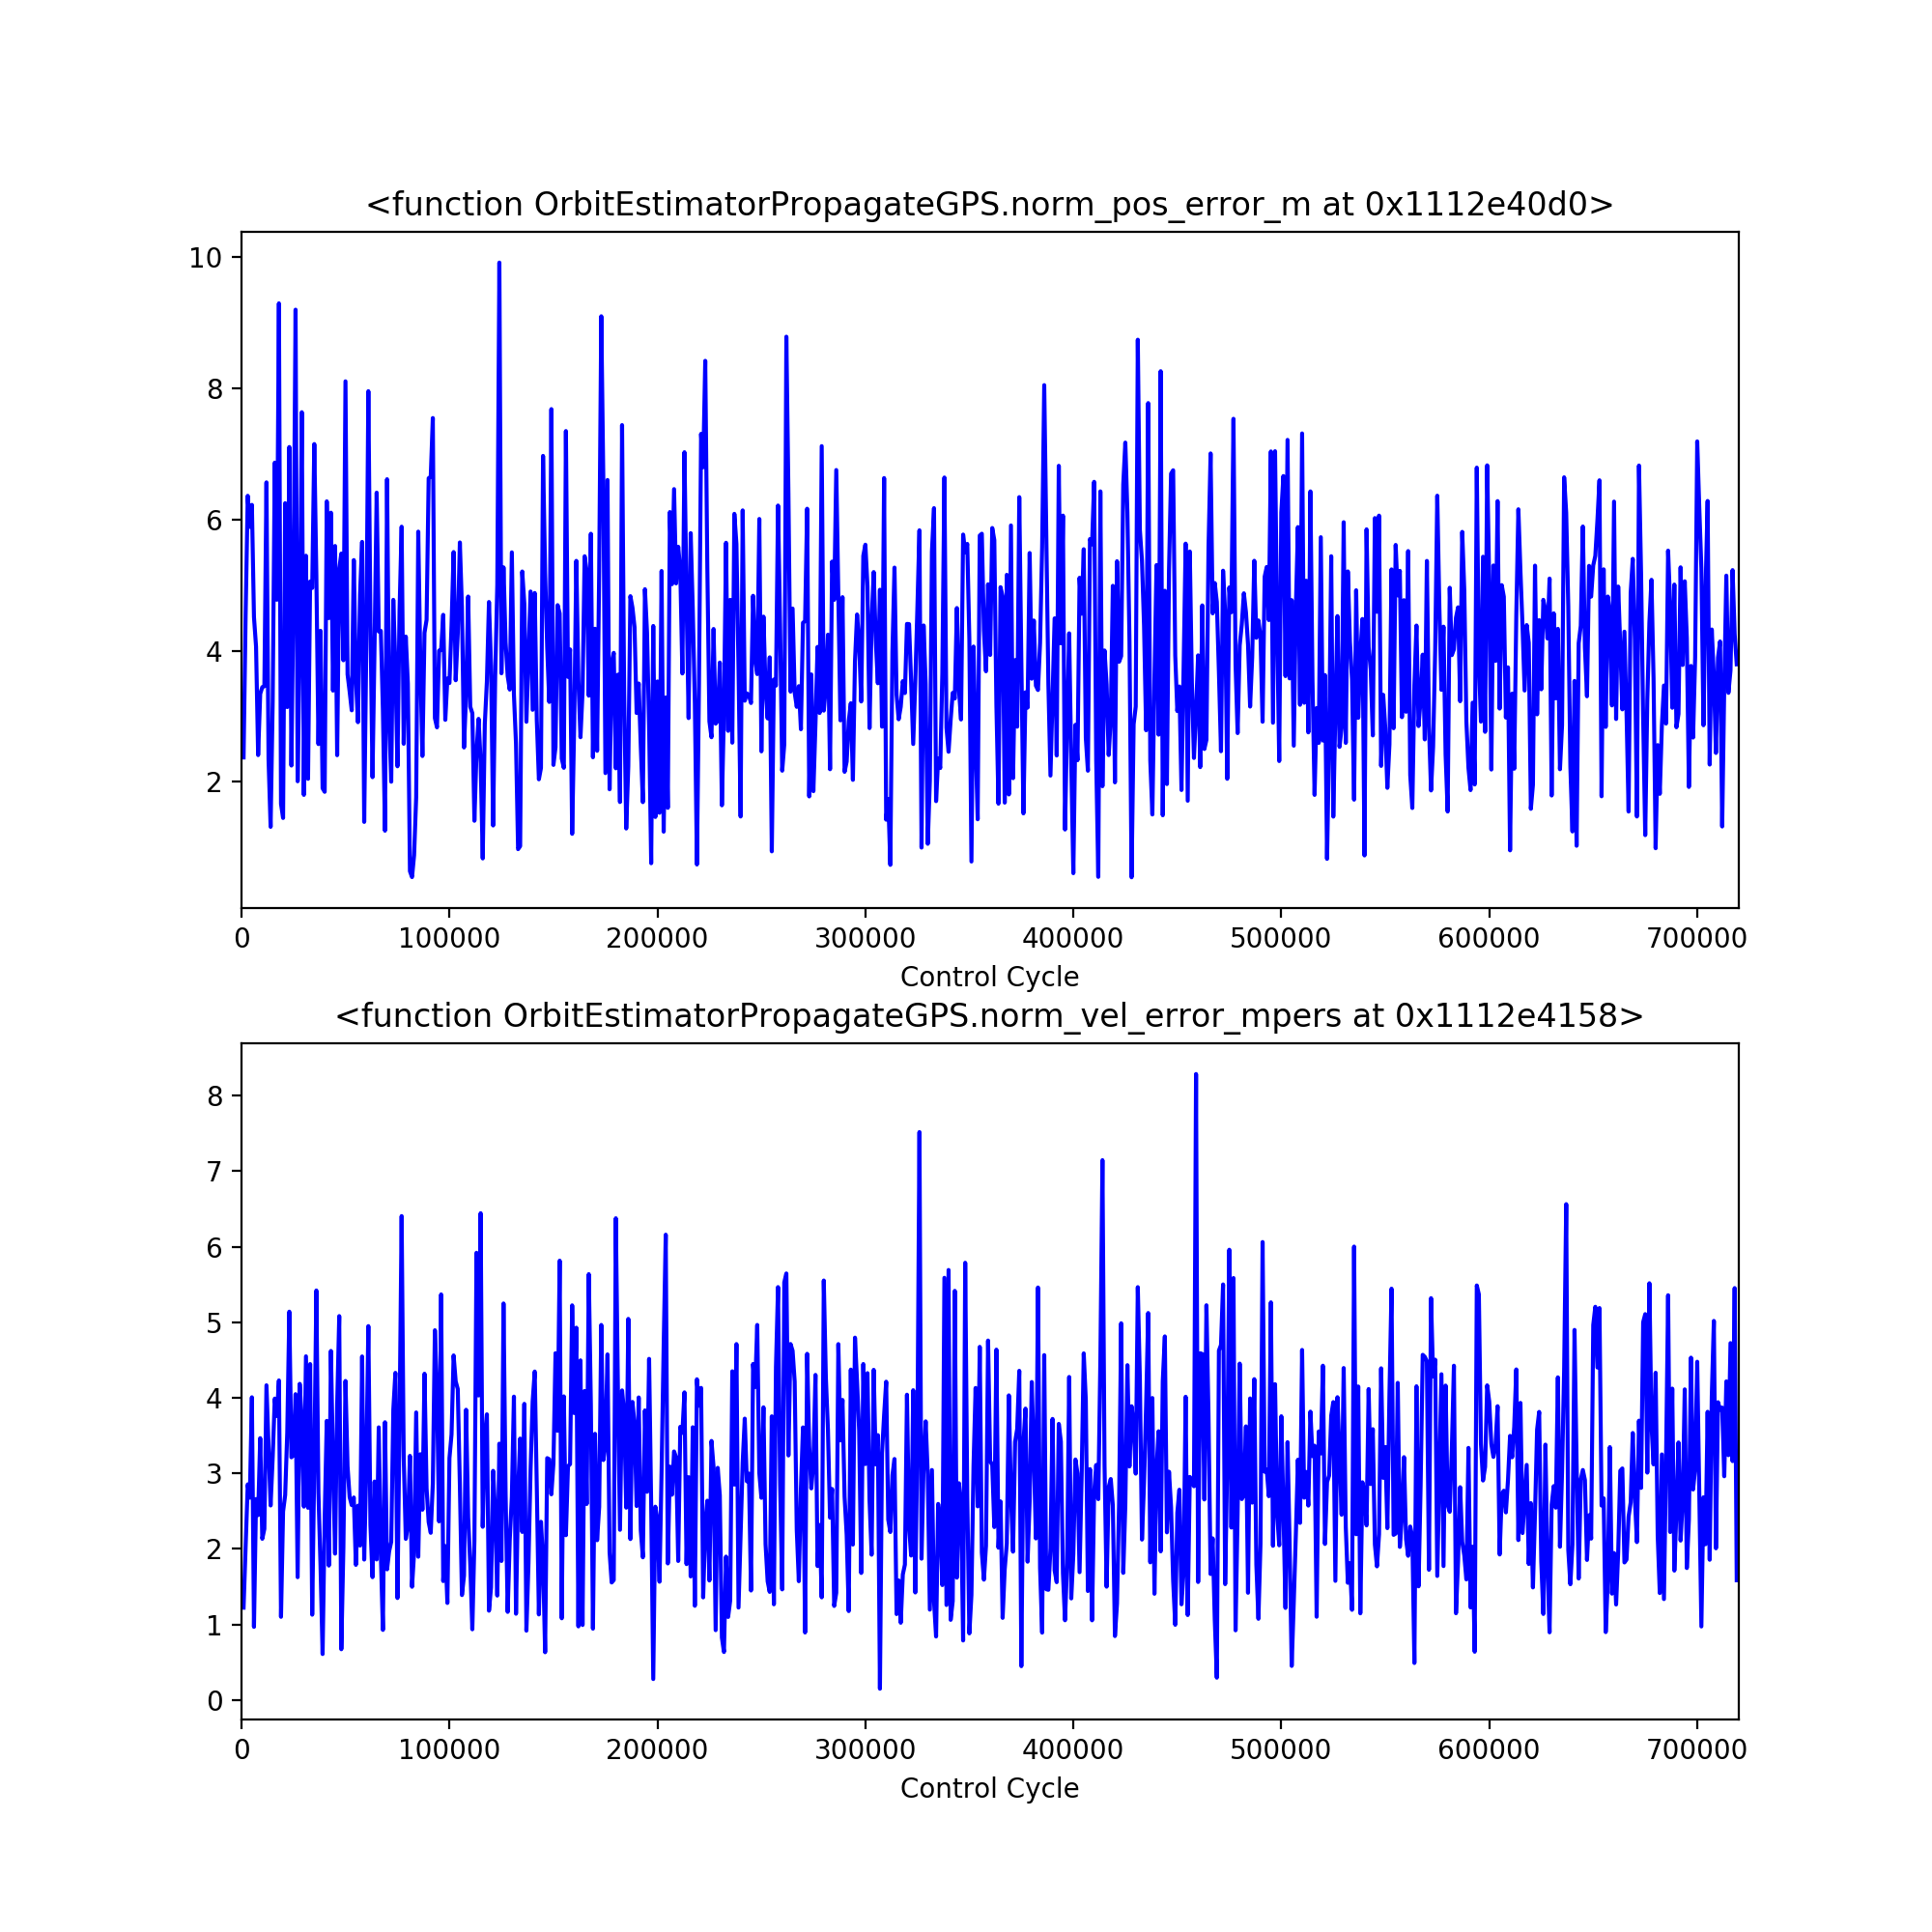

In [10]:
graceb=[]
samplerate=1000
a= estimatorscope(OrbitEstimatorPropagateGPS(),gracetruth,gracesensors,graceb,samplerate,
                      [OrbitEstimatorPropagateGPS.norm_pos_error_m,
                       OrbitEstimatorPropagateGPS.norm_vel_error_mpers])
plt.show()